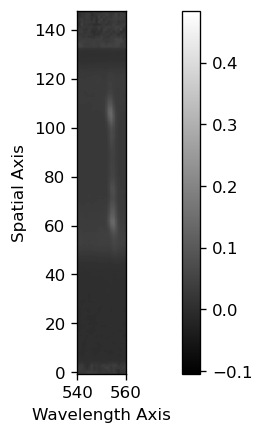

In [2]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 140
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model

import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p_map.ipynb.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec >= 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec >= 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec >= 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec >= 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec >= 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

fn_spec = 85 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
target_spec = nirspec7_data_array[fn_spec-start_nirspec7]
sky_subtracted = (target_spec - sky_total) / (average_flat_field - average_flat_lamp_off)
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
plt.figure(figsize=(12,4))
#plt.imshow(sky_subtracted, aspect='auto', extent=[waverange[0], waverange[-1], 148 ,0], cmap='gist_gray')
plt.imshow(sky_subtracted, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.xlim(540,560)
#plt.ylim(10,130)
plt.colorbar()

# a = np.delete(sky_subtracted, np.s_[200:], 1)
# b = np.delete(a, np.s_[:85], 1)
# c = np.delete(b, np.s_[50:], 1)
# plt.figure(figsize=(2,4))
# plt.imshow(c,aspect='auto', extent=[waverange[85], waverange[134], 148 ,0], cmap='afmhot')
# plt.gca().invert_yaxis()
# plt.xlim(2.1216,2.1219)
# plt.colorbar()

In [488]:
# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# confirm start and end frame number
fn_start = 61
fn_end = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

# create empty list to collect result
h2_a0_map = []
h2_a1_map = []
h2_a2_map = []


print('H2 LOOP START')
print()
# scan selected range of frames
for fn in range(fn_start, fn_end):
    # check if selected frame is a sky frame
    if fn in sky_frame:
        print('Frame Number = ' + str(fn) + '(Sky Frame)')
        print()
        continue
    # perform sky subtraction
    skyfinal = scale_sky_frame(fn)
    sky_subtract = (nirspec7_data_array[fn-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    # select waverange for gaussian fit
    a = np.delete(sky_subtract, np.s_[200:], 1)
    b = np.delete(a, np.s_[:85], 1)
    c = np.delete(b, np.s_[50:], 1)
    
    # define new wavlength axis
    pixel = np.linspace(0, np.size(c, 1), np.size(c, 1))
    
    # partition frame numbers to account for change in spatial axis
    if fn >= 84 and fn < fn_end:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 132
        lower_h2 = 37

        h2_a0 = np.zeros(148)
        h2_a1 = np.zeros(148)
        h2_a2 = np.zeros(148)
        
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            #if i >= 103 and i < upper_h2:
            # create lmfit model with defined gaussian
            h2_model = Model(gaussian_fit)

            # create parameters and add initial guess
            h2_params = h2_model.make_params()
            h2_params.add('a0', value=0.1)
            h2_params.add('a1', value=23)
            h2_params.add('a2', value=2)
            h2_params.add('a3', value=0)
            h2_params.add('a4', value=0)
            h2_params.add('a5', value=0)
                
            # perform gaussian fit and test errors
            try:
                h2_fit_result = h2_model.fit(c[i], h2_params, x=waverange)
            except ValueError:
                print('ValueError occured at i=' + str(i))
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
                
            # collect fitting parameters
            #print(h2_fit_result.fit_report())
            h2_a0[i] = h2_fit_result.params['a0'].value
            h2_a1[i] = h2_fit_result.params['a1'].value
            h2_a2[i] = h2_fit_result.params['a2'].value
            
    # partition frame numbers to account for change in spatial axis
    if fn >= 80 and fn < 84:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 132
        lower_h2 = 37

        h2_a0 = np.zeros(148)
        h2_a1 = np.zeros(148)
        h2_a2 = np.zeros(148)
        
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            #if i >= 103 and i < upper_h2:
            # create lmfit model with defined gaussian
            h2_model = Model(gaussian_fit)

            # create parameters and add initial guess
            h2_params = h2_model.make_params()
            h2_params.add('a0', value=0.1)
            h2_params.add('a1', value=23)
            h2_params.add('a2', value=2)
            h2_params.add('a3', value=0)
            h2_params.add('a4', value=0)
            h2_params.add('a5', value=0)
                
            # perform gaussian fit and test errors
            try:
                h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
            except ValueError:
                print('ValueError occured at i=' + str(i))
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
                
            # collect fitting parameters
            #print(h2_fit_result.fit_report())
            h2_a0[i] = h2_fit_result.params['a0'].value
            h2_a1[i] = h2_fit_result.params['a1'].value
            h2_a2[i] = h2_fit_result.params['a2'].value
    
    # partition frame numbers to account for change in spatial axis       
    if fn >= 73 and fn < 80:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 100
        lower_h2 = 10

        h2_a0 = np.zeros(148)
        h2_a1 = np.zeros(148)
        h2_a2 = np.zeros(148)
            
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            #if i >= 103 and i < upper_h2:
            # create lmfit model with defined gaussian
            h2_model = Model(gaussian_fit)

            # create parameters and add initial guess
            h2_params = h2_model.make_params()
            h2_params.add('a0', value=0.03)
            h2_params.add('a1', value=24)
            h2_params.add('a2', value=2)
            h2_params.add('a3', value=0)
            h2_params.add('a4', value=0)
            h2_params.add('a5', value=0)
                
            # perform gaussian fit and test errors
            try:
                h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
            except ValueError:
                print('ValueError occured at i=' + str(i))
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
                
            # collect fitting parameters
            #print(h2_fit_result.fit_report())
            h2_a0[i] = h2_fit_result.params['a0'].value
            h2_a1[i] = h2_fit_result.params['a1'].value
            h2_a2[i] = h2_fit_result.params['a2'].value
            
    # partition frame numbers to account for change in spatial axis       
    if fn >= 68 and fn < 73:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 105
        lower_h2 = 15

        h2_a0 = np.zeros(148)
        h2_a1 = np.zeros(148)
        h2_a2 = np.zeros(148)
            
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            #if i >= 103 and i < upper_h2:
            # create lmfit model with defined gaussian
            h2_model = Model(gaussian_fit)

            # create parameters and add initial guess
            h2_params = h2_model.make_params()
            h2_params.add('a0', value=0.03)
            h2_params.add('a1', value=24)
            h2_params.add('a2', value=2)
            h2_params.add('a3', value=0)
            h2_params.add('a4', value=0)
            h2_params.add('a5', value=0)
                
            # perform gaussian fit and test errors
            try:
                h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
            except ValueError:
                print('ValueError occured at i=' + str(i))
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
                
            # collect fitting parameters
            #print(h2_fit_result.fit_report())
            h2_a0[i] = h2_fit_result.params['a0'].value
            h2_a1[i] = h2_fit_result.params['a1'].value
            h2_a2[i] = h2_fit_result.params['a2'].value
        
    # partition frame numbers to account for change in spatial axis       
    if fn >= fn_start and fn < 68:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 110
        lower_h2 = 30

        h2_a0 = np.zeros(148)
        h2_a1 = np.zeros(148)
        h2_a2 = np.zeros(148)
            
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            if i >= 70 and i < upper_h2:
            # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.15)
                h2_params.add('a1', value=22)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                h2_a0[i] = h2_fit_result.params['a0'].value
                h2_a1[i] = h2_fit_result.params['a1'].value
                h2_a2[i] = h2_fit_result.params['a2'].value
                
            # different initial guess for different spatial range
            if i >= 30 and i < 70:
            # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.05)
                h2_params.add('a1', value=23)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                h2_a0[i] = h2_fit_result.params['a0'].value
                h2_a1[i] = h2_fit_result.params['a1'].value
                h2_a2[i] = h2_fit_result.params['a2'].value
                
            # different initial guess for different spatial range
            if i >= lower_h2 and i < 30:
            # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.03)
                h2_params.add('a1', value=22)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                h2_a0[i] = h2_fit_result.params['a0'].value
                h2_a1[i] = h2_fit_result.params['a1'].value
                h2_a2[i] = h2_fit_result.params['a2'].value
    print()
    
    # Collect fitting parameters of each frame number   
    h2_a0_map.append(h2_a0)
    h2_a1_map.append(h2_a1)
    h2_a2_map.append(h2_a2)
    
print('DONE')

H2 LOOP START

Frame Number = 61

Frame Number = 62

Frame Number = 63

Frame Number = 64

Frame Number = 65
ValueError occured at i=106

Frame Number = 66

Frame Number = 67

Frame Number = 68
ValueError occured at i=15
ValueError occured at i=74
ValueError occured at i=78
ValueError occured at i=79
ValueError occured at i=81
ValueError occured at i=82
ValueError occured at i=88

Frame Number = 69
ValueError occured at i=71
ValueError occured at i=72
ValueError occured at i=76
ValueError occured at i=104

Frame Number = 70
ValueError occured at i=102

Frame Number = 71
ValueError occured at i=101
ValueError occured at i=103

Frame Number = 72(Sky Frame)

Frame Number = 73
ValueError occured at i=98

Frame Number = 74
ValueError occured at i=96

Frame Number = 75
ValueError occured at i=78
ValueError occured at i=90
ValueError occured at i=91
ValueError occured at i=94
ValueError occured at i=95

Frame Number = 76
ValueError occured at i=76
ValueError occured at i=78
ValueError occured

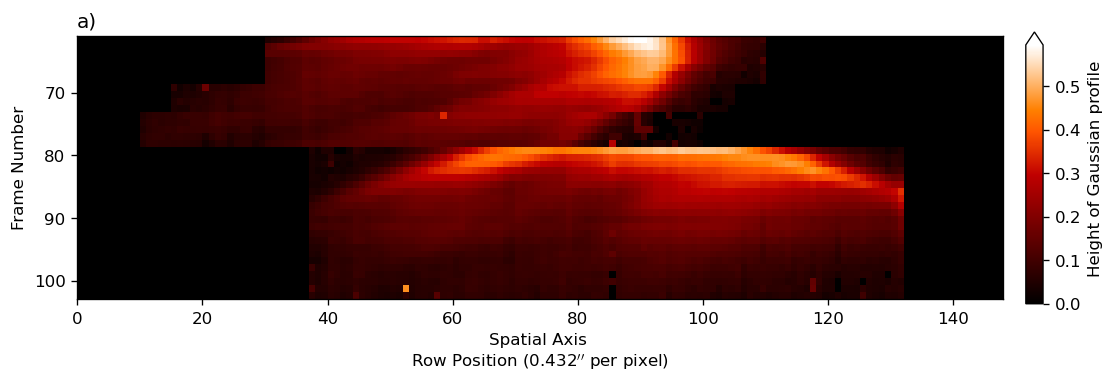

In [489]:
h2a0 = np.vstack((h2_a0_map))
h2a0[h2a0>0.4] = 0
h2a0[h2a0<0] = 0

plt.figure(figsize=(12,3))
plt.imshow(np.sqrt(h2a0), extent=[0, 148, fn_end, fn_start], cmap='gist_heat')
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title('a)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Height of Gaussian profile')
#plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Intensity (Wm$^{-2}$sr$^{-1}$)')
#plt.savefig('plots/h2_a0_map_107', bbox_inches='tight')

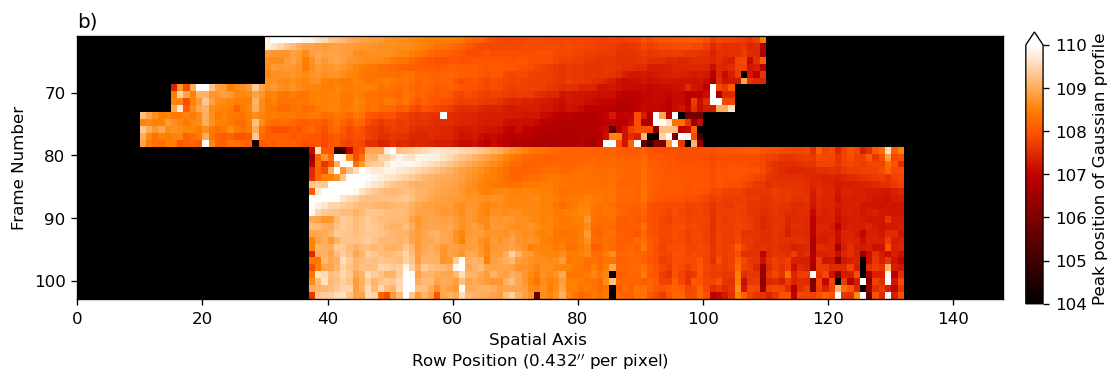

In [501]:
h2a1 = np.vstack((h2_a1_map))+85
h2a1[h2a1>110] = 110
h2a1[h2a1<104] = 104

plt.figure(figsize=(12,3))
plt.imshow(h2a1, extent=[0, 148, fn_end, fn_start], cmap='gist_heat')
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title('b)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Peak position of Gaussian profile')
#plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Intensity (Wm$^{-2}$sr$^{-1}$)')
#plt.savefig('plots/h2_a1_map_107', bbox_inches='tight')

In [3]:
# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# create lmfit model with defined gaussian
h2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(h2_model.param_names))
#print('independent variables: {}'.format(h2_model.independent_vars))


# create parameters and add initial guess
h2_params = h2_model.make_params()
h2_params.add('a0', value=0.2)
h2_params.add('a1', value=107)
h2_params.add('a2', value=1)
h2_params.add('a3', value=0)
h2_params.add('a4', value=0)
h2_params.add('a5', value=0)

"""
repeat same step for h2 a0 at wavelength axis 107
"""

lower_h2 = 10
upper_h2 = 140

fn_start = 60
fn_end = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h2_a0_map = []
h2_a1_map = []
h2_a2_map = []

for i in range(fn_start, fn_end):
    print('Frame Number = ' + str(i))
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    #plt.figure()
    #plt.imshow(sky_subtract, cmap='gist_gray')
    #plt.title('frame number ' + str(i))
    
    h2_a0 = np.zeros(upper_h2-lower_h2)
    h2_a1 = np.zeros(upper_h2-lower_h2)
    h2_a2 = np.zeros(upper_h2-lower_h2)
    
    for j in range(lower_h2, upper_h2):
        try:
            h2_fit_result = h2_model.fit(sky_subtract[j], h2_params, x=pixel)
            h2_a0[j] = h2_fit_result.params['a0'].value
            h2_a1[j] = h2_fit_result.params['a1'].value
            h2_a2[j] = h2_fit_result.params['a2'].value
        except:
            pass
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a0', fontsize=12)
    #plt.plot(h2_a0)
    
    h2_a0_map.append(h2_a0)
    h2_a1_map.append(h2_a1)
    h2_a2_map.append(h2_a2)
    
print('Done')

Frame Number = 60
Frame Number = 61
Frame Number = 62
Frame Number = 63
Frame Number = 64
Frame Number = 65
Frame Number = 66
Frame Number = 67
Frame Number = 68
Frame Number = 69
Frame Number = 70
Frame Number = 71
Frame Number = 72
Frame Number = 73
Frame Number = 74
Frame Number = 75
Frame Number = 76
Frame Number = 77
Frame Number = 78
Frame Number = 79
Frame Number = 80
Frame Number = 81
Frame Number = 82
Frame Number = 83
Frame Number = 84
Frame Number = 85
Frame Number = 86
Frame Number = 87
Frame Number = 88
Frame Number = 89
Frame Number = 90
Frame Number = 91
Frame Number = 92
Frame Number = 93
Frame Number = 94
Frame Number = 95
Frame Number = 96
Frame Number = 97
Frame Number = 98
Frame Number = 99
Frame Number = 100
Frame Number = 101
Frame Number = 102
Done


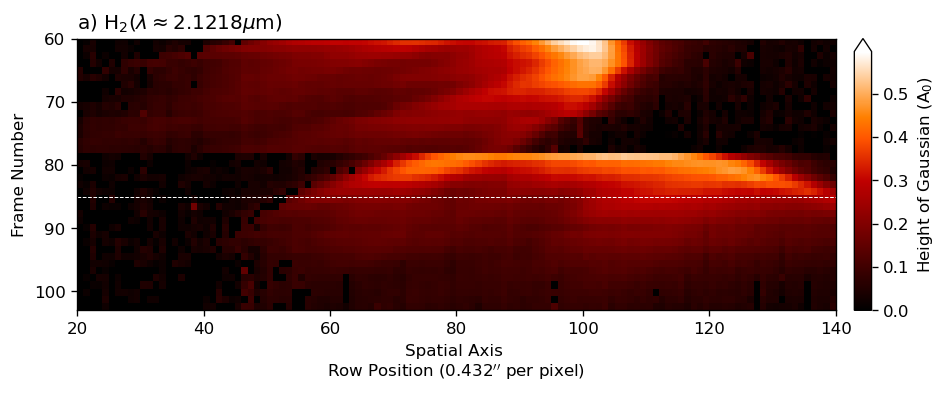

In [5]:
h2a0 = np.vstack((h2_a0_map))
h2a0[h2a0<0] = 0
h2a0[h2a0>0.4] = 0

plt.figure(figsize=(10,3))
plt.imshow(np.sqrt(h2a0), extent=[lower_h2, upper_h2, fn_end, fn_start], cmap='gist_heat')
plt.axhline(y=85, c='white', ls='--', lw=0.6)
plt.xlim(20,140)
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title(r'a) H$_2$($\lambda$$\approx$' + str(round(waverange[107], 4)) + '$\mu$m)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Height of Gaussian (A$_0$)')
plt.savefig('poster/a0map_h2', bbox_inches='tight', dpi=1000)

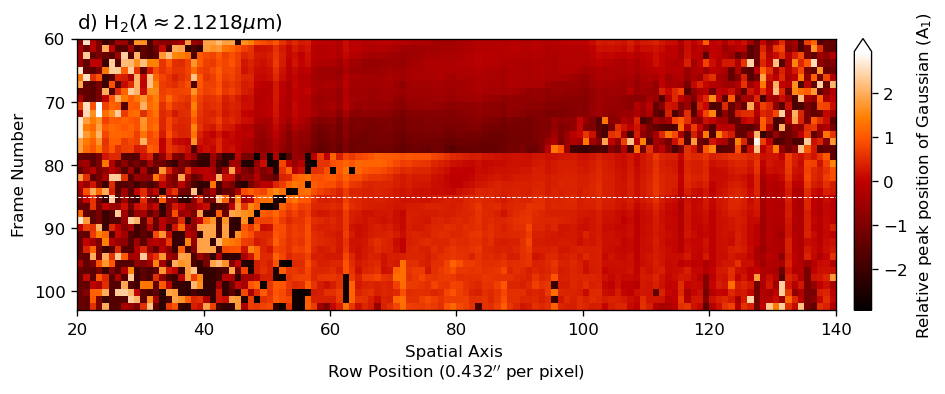

In [6]:
h2a1 = np.vstack((h2_a1_map))
h2a1[h2a1<105.5] = 105.5
h2a1[h2a1>109.5] = 109.5

plt.figure(figsize=(10,3))
plt.imshow(h2a1-(np.sum(h2a1, axis=0)/len(h2a1)), extent=[lower_h2, upper_h2, fn_end, fn_start], cmap='gist_heat')
plt.xlim(20,140)
plt.axhline(y=85, c='white', ls='--', lw=0.6)
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title(r'd) H$_2$($\lambda$$\approx$' + str(round(waverange[107], 4)) + '$\mu$m)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Relative peak position of Gaussian (A$_1$)')
plt.savefig('poster/a1map_h2', bbox_inches='tight', dpi=1000)

In [7]:
# create lmfit model with defined gaussian
h3p_model = Model(gaussian_fit)

h3p_params = h3p_model.make_params()
h3p_params.add('a0', value=0.2)
h3p_params.add('a1', value=555)
h3p_params.add('a2', value=2)
h3p_params.add('a3', value=0)
h3p_params.add('a4', value=0)
h3p_params.add('a5', value=0)

"""
repeat for h3p a0 at wavelength axis 554
"""

lower_h3p = 10
upper_h3p = 140


fn_start = 60
fn_end = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a0_map = []
h3p_a1_map = []

for i in range(fn_start, fn_end):
    print('Frame Number = ' + str(i))
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    h3p_a0 = np.zeros(upper_h3p-lower_h3p)
    h3p_a1 = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result = h3p_model.fit(sky_subtract[j], h3p_params, x=pixel)
            h3p_a0[j] = h3p_fit_result.params['a0'].value
            h3p_a1[j] = h3p_fit_result.params['a1'].value
        except:
            pass
    
    h3p_a0_map.append(h3p_a0)
    h3p_a1_map.append(h3p_a1)
    
print('Done')

Frame Number = 60
Frame Number = 61
Frame Number = 62
Frame Number = 63
Frame Number = 64
Frame Number = 65
Frame Number = 66
Frame Number = 67
Frame Number = 68
Frame Number = 69
Frame Number = 70
Frame Number = 71
Frame Number = 72
Frame Number = 73
Frame Number = 74
Frame Number = 75
Frame Number = 76
Frame Number = 77
Frame Number = 78
Frame Number = 79
Frame Number = 80
Frame Number = 81
Frame Number = 82
Frame Number = 83
Frame Number = 84
Frame Number = 85
Frame Number = 86
Frame Number = 87
Frame Number = 88
Frame Number = 89
Frame Number = 90
Frame Number = 91
Frame Number = 92
Frame Number = 93
Frame Number = 94
Frame Number = 95
Frame Number = 96
Frame Number = 97
Frame Number = 98
Frame Number = 99
Frame Number = 100
Frame Number = 101
Frame Number = 102
Done


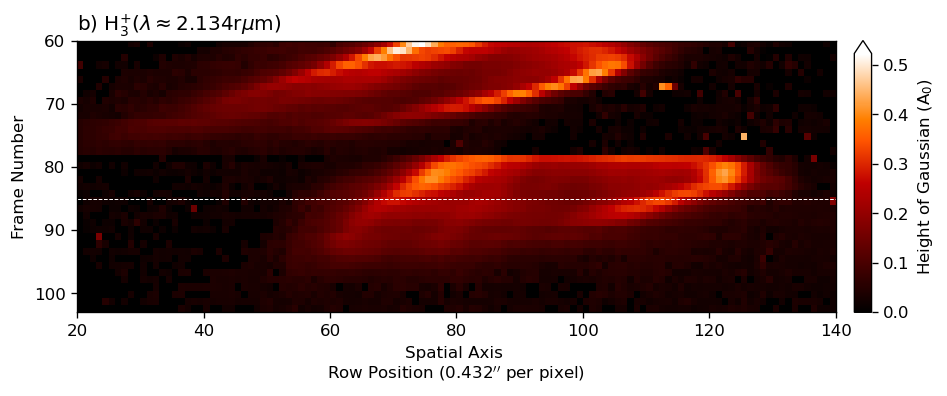

In [8]:
h3pa0 = np.vstack((h3p_a0_map))
h3pa0[h3pa0<0] = 0
h3pa0[h3pa0>0.4] = 0

plt.figure(figsize=(10,3))
plt.imshow(np.sqrt(h3pa0), extent=[lower_h3p, upper_h3p, fn_end, fn_start], cmap='gist_heat')
plt.axhline(y=85, c='white', ls='--', lw=0.6)
plt.xlim(20,140)
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title(r'b) H$_3^{+}$($\lambda$$\approx$' + str(round(waverange[555], 4)) + 'r$\mu$m)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Height of Gaussian (A$_0$)')
plt.savefig('poster/a0map_h3p_1', bbox_inches='tight', dpi=1000)

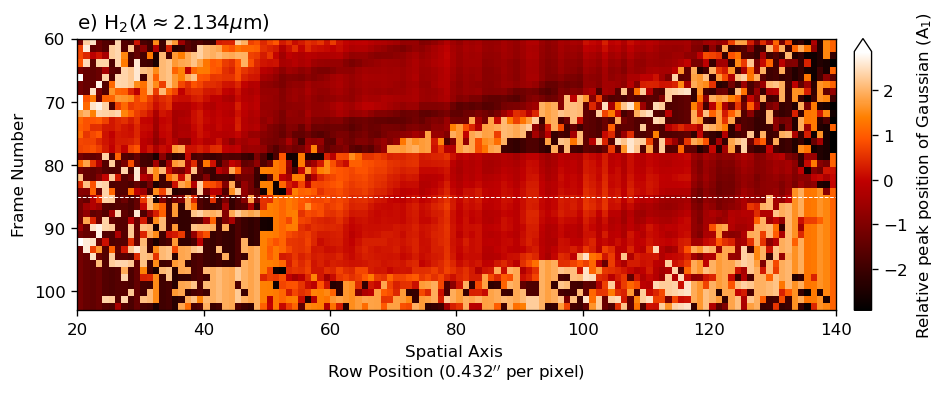

In [9]:
h3pa1 = np.vstack((h3p_a1_map))
h3pa1[h3pa1<553] = 553
h3pa1[h3pa1>557] = 557

plt.figure(figsize=(10,3))
plt.imshow(h3pa1-(np.sum(h3pa1, axis=0)/len(h3pa1)), extent=[lower_h3p, upper_h3p, fn_end, fn_start], cmap='gist_heat')
plt.xlim(20,140)
plt.axhline(y=85, c='white', ls='--', lw=0.6)
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title(r'e) H$_2$($\lambda$$\approx$' + str(round(waverange[555], 4)) + r'$\mu$m)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Relative peak position of Gaussian (A$_1$)')
plt.savefig('poster/a1map_h3p_1', bbox_inches='tight', dpi=1000)

In [10]:
# create lmfit model with defined gaussian
h3p_model = Model(gaussian_fit)

h3p_params = h3p_model.make_params()
h3p_params.add('a0', value=0.1)
h3p_params.add('a1', value=874)
h3p_params.add('a2', value=2)
h3p_params.add('a3', value=0)
h3p_params.add('a4', value=0)
h3p_params.add('a5', value=0)

"""
repeat for h3p a0 at wavelength axis 554
"""

lower_h3p = 10
upper_h3p = 140


fn_start = 60
fn_end = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a0_map_2 = []
h3p_a1_map_2 = []
#h3p_a2_map = []

for i in range(fn_start, fn_end):
    print('Frame Number = ' + str(i))
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    h3p_a0_2 = np.zeros(upper_h3p-lower_h3p)
    h3p_a1_2 = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result = h3p_model.fit(sky_subtract[j], h3p_params, x=pixel)
            h3p_a0_2[j] = h3p_fit_result.params['a0'].value
            h3p_a1_2[j] = h3p_fit_result.params['a1'].value
        except:
            pass
    
    h3p_a0_map_2.append(h3p_a0_2)
    h3p_a1_map_2.append(h3p_a1_2)
    
print('Done')

Frame Number = 60
Frame Number = 61
Frame Number = 62
Frame Number = 63
Frame Number = 64
Frame Number = 65
Frame Number = 66
Frame Number = 67
Frame Number = 68
Frame Number = 69
Frame Number = 70
Frame Number = 71
Frame Number = 72
Frame Number = 73
Frame Number = 74
Frame Number = 75
Frame Number = 76
Frame Number = 77
Frame Number = 78
Frame Number = 79
Frame Number = 80
Frame Number = 81
Frame Number = 82
Frame Number = 83
Frame Number = 84
Frame Number = 85
Frame Number = 86
Frame Number = 87
Frame Number = 88
Frame Number = 89
Frame Number = 90
Frame Number = 91
Frame Number = 92
Frame Number = 93
Frame Number = 94
Frame Number = 95
Frame Number = 96
Frame Number = 97
Frame Number = 98
Frame Number = 99
Frame Number = 100
Frame Number = 101
Frame Number = 102
Done


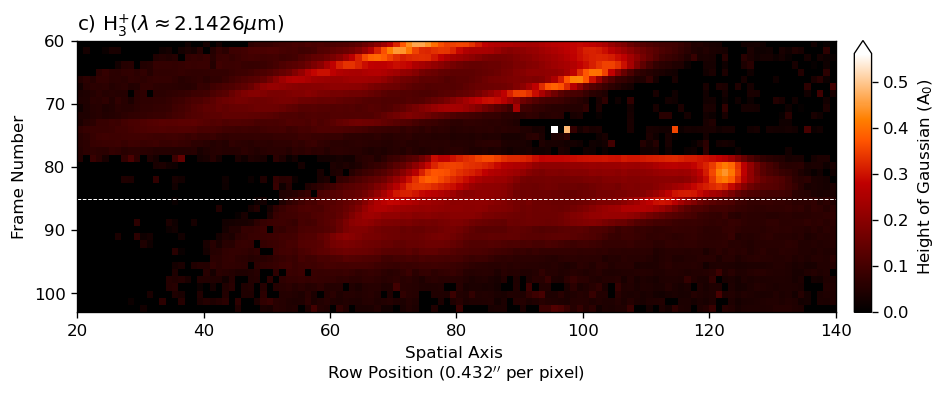

In [11]:
h3pa0_2 = np.vstack((h3p_a0_map_2))
h3pa0_2[h3pa0_2<0] = 0
h3pa0_2[h3pa0_2>0.4] = 0

plt.figure(figsize=(10,3))
plt.imshow(np.sqrt(h3pa0_2), extent=[lower_h3p, upper_h3p, fn_end, fn_start], cmap='gist_heat')
plt.axhline(y=85, c='white', ls='--', lw=0.6)
plt.xlim(20,140)
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title(r'c) H$_3^{+}$($\lambda$$\approx$' + str(round(waverange[874], 4)) + '$\mu$m)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Height of Gaussian (A$_0$)')
plt.savefig('poster/a0map_h3p_2', bbox_inches='tight', dpi=1000)

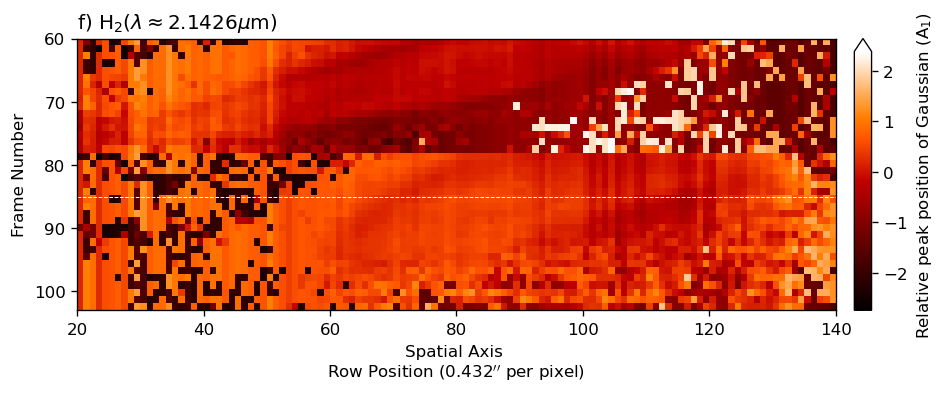

In [12]:
h3pa1_2 = np.vstack((h3p_a1_map_2))
h3pa1_2[h3pa1_2<873] = 873
h3pa1_2[h3pa1_2>876] = 876

plt.figure(figsize=(10,3))
plt.imshow(h3pa1_2-(np.sum(h3pa1_2, axis=0)/len(h3pa1_2)), extent=[lower_h3p, upper_h3p, fn_end, fn_start], cmap='gist_heat')
plt.xlim(20,140)
plt.axhline(y=85, c='white', ls='--', lw=0.6)
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title(r'f) H$_2$($\lambda$$\approx$' + str(round(waverange[874], 4)) + '$\mu$m)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Relative peak position of Gaussian (A$_1$)')
plt.savefig('poster/a1map_h3p_2', bbox_inches='tight', dpi=1000)

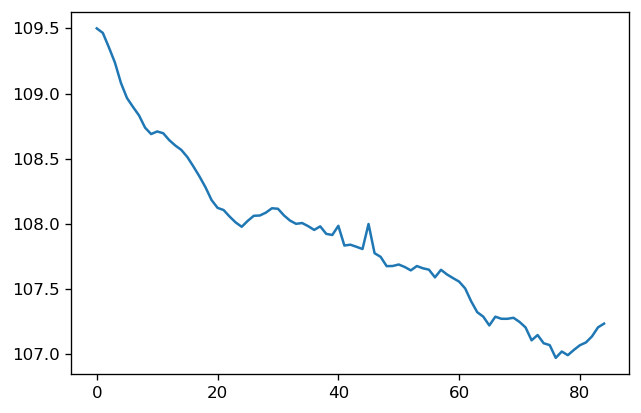

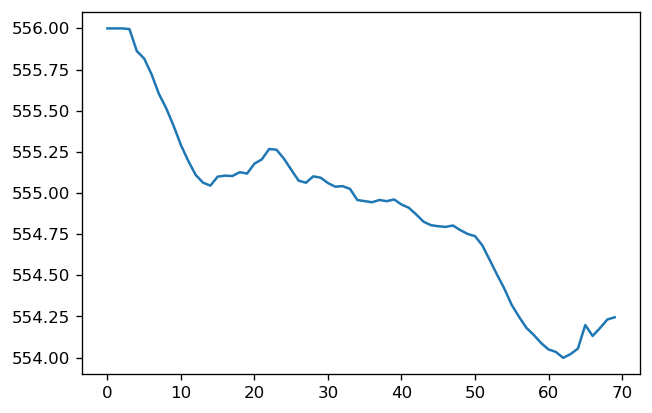

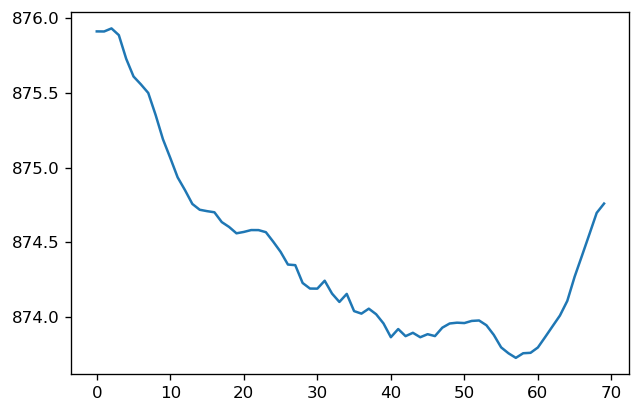

In [302]:
plt.figure()
plt.plot(h2a1[21][45:130])

plt.figure()
plt.plot(h3pa1[21][50:120])

plt.figure()
plt.plot(h3pa1_2[21][50:120])

In [258]:
np.median(np.sum(h3pa1_2, axis=0)/len(h3pa1_2))

874.3504561338559

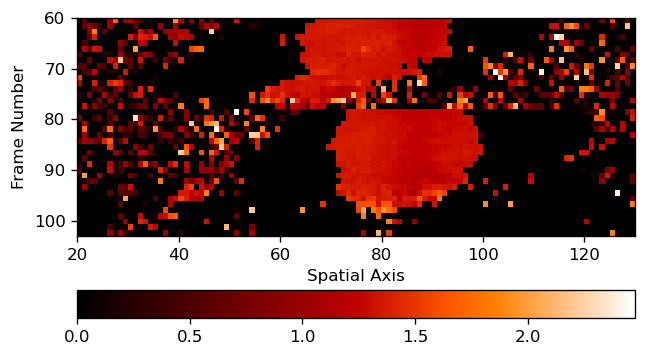

In [78]:
h3pa2 = np.vstack((h3p_a2_map))
h3pa2[h3pa2<0] = 0
h3pa2[h3pa2>2.5] = 0

plt.imshow(h3pa2, extent=[lower_h3p, upper_h3p, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.xlim(20,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h3p_a2_map_554', bbox_inches='tight')

In [66]:
# create lmfit model with defined gaussian
h3p_model_2 = Model(gaussian_fit)

h3p_params_2 = h3p_model.make_params()
h3p_params_2.add('a0', value=0.1)
h3p_params_2.add('a1', value=853)
h3p_params_2.add('a2', value=1)
h3p_params_2.add('a3', value=0)
h3p_params_2.add('a4', value=0)
h3p_params_2.add('a5', value=0)

In [67]:
"""
repeat for h3p a0 at wavelength axis 874
"""

lower_h3p = 10
upper_h3p = 130


start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a0_map_2 = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    h3p_a0_2 = np.zeros(upper_h3p-lower_h3p)
    #h3p_a0_error = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result_2 = h3p_model_2.fit(sky_subtract[j], h3p_params_2, x=pixel)
            h3p_a0_2[j] = h3p_fit_result_2.params['a0'].value
        except:
            pass
    h3p_a0_2[h3p_a0_2<0] = 0
    h3p_a0_2[h3p_a0_2>0.25] = 0
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a0', fontsize=12)
    #plt.title('frame number ' + str(i))
    #plt.plot(np.linspace(lower_h3p, upper_h3p, len(h3p_a0_2)), h3p_a0_2)
    
    h3p_a0_map_2.append(h3p_a0_2)
    
print('Done')

Done


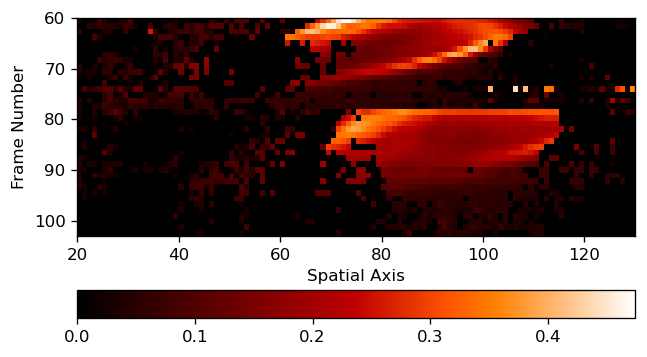

In [77]:
h3pa0_2 = np.vstack((h3p_a0_map_2))
h3pa0_2[h3pa0_2<0] = 0

plt.imshow(np.sqrt(h3pa0_2), extent=[lower_h3p, upper_h3p, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.xlim(20,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h3p_a0_map_874', bbox_inches='tight')

In [69]:
"""
repeat for h3p a1 at wavelength axis 874
"""

lower_h3p = 10
upper_h3p = 130


start_kband_north = 60
end_kband_north = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

h3p_a1_map_2 = []

for i in range(start_kband_north+1, end_kband_north):
    if i in sky_frame:
        continue
    skyfinal = scale_sky_frame(i)
    sky_subtract = (nirspec7_data_array[i-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    h3p_a1_2 = np.zeros(upper_h3p-lower_h3p)
    
    for j in range(lower_h3p, upper_h3p):
        try:
            h3p_fit_result_2 = h3p_model_2.fit(sky_subtract[j], h3p_params_2, x=pixel)
            h3p_a1_2[j] = h3p_fit_result_2.params['a1'].value
        except:
            pass
    
    #plt.figure()
    #plt.xlabel('spatial axis', fontsize=12)
    #plt.ylabel('a1', fontsize=12)
    #plt.title('frame number ' + str(i))
    #plt.plot(np.linspace(lower_h3p, upper_h3p, len(h3p_a1_2)), h3p_a1_2)
    
    h3p_a1_map_2.append(h3p_a1_2)
    
print('Done')

Done


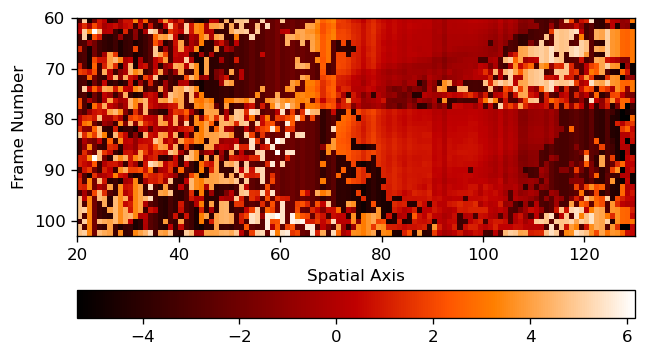

In [76]:
h3pa1_2 = np.vstack((h3p_a1_map_2))
h3pa1_2[h3pa1_2<849] = 849
h3pa1_2[h3pa1_2>857] = 857

plt.imshow(h3pa1_2-np.sum(h3pa1_2, axis=0)/len(h3pa1_2), extent=[lower_h3p, upper_h3p, end_kband_north, start_kband_north], cmap='gist_heat')
plt.xlabel('Spatial Axis')
plt.ylabel('Frame Number')
plt.xlim(20,130)
plt.colorbar(orientation='horizontal', pad=0.15)
#plt.savefig('plots/h3p_a1_map_874', bbox_inches='tight')